# Gold mining (the start)

This notebook is a part of the series about using ProcessOptimizer to guide a gold
mining expedition. For an overview, go to the markdown file gold_mining.md

## Our plot of land

We start the story of our gold mining expedition here. We have just gotten the
prospecting permit for a plot of land, and want to figure out how to find the highest
amount of gold. First, we want to figure out where to dig. But since each dig takes a
long time, we want to make as few digs as possible. 

The plot of land is 15.0 by 15.0 kilometers. We define this in the `coordinates`
variable.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import ProcessOptimizer
from ProcessOptimizer.model_systems import gold_map

coordinates = [(0.0, 15.0), (0.0, 15.0)]

## The secret map
Next, we make a (secret) map of all the gold in the plot of land. We do this by making
a score function<sup>1</sup> which accepts a coordinate and returns the amount of gold found when
digging at those coordinates. 

We then plot the secret gold map. The yellow areas contain a lot of gold, the green
areas less gold, and the blue areas no gold.

<sup>1</sup>Note that the score function returns minus the amount of gold found. This is because
the ProcessOptimizer is allways a minimizer. So if we want to find a maximum, we have to
feed it minus the objective function. 

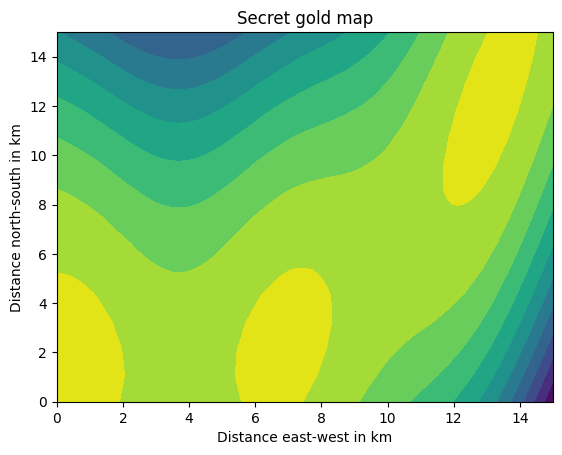

In [8]:


x_list = np.linspace(coordinates[0][0],coordinates[0][1],100)
y_list = np.linspace(coordinates[1][0],coordinates[1][1],15,100)

(x_mesh,y_mesh) = np.meshgrid(x_list,y_list)
score_mesh = [[-gold_map.get_score((x,y)) for (x,y) in zip(x_vec,y_vec)] 
              for (x_vec,y_vec) in zip(x_mesh,y_mesh)]
plot = plt.contourf(x_mesh,y_mesh,score_mesh,10)
plot.axes.set_xlabel("Distance east-west in km")
plot.axes.set_ylabel("Distance north-south in km")
plot.axes.set_title("Secret gold map");

**Note that this map is SECRET, and our prospectors don't know anything about it, and
can only learn about the value in specifics points, and only by digging.**

## Starting to dig

We can now start our prospecting. We could, for example, dig at the point in the middle
of the map, which has the coordinates `[7.5,7.5]`. We send out digging team, lead by Ms.
Goldie Dixon, to this position and tell them to dig and report how much gold they found
by calling `score([7.5,7.5])`.

In [9]:
first_gold_found = gold_map.get_score([7.5,7.5])
print("Amount of gold found: ", -first_gold_found)

Amount of gold found:  2.8474483459296933


## The ProcessOptimizer

But we don't want to dig at random points, and we don't want to manually keep track of
where we have dug so far and how much gold we found there. We want some way to keep
track of our knowledge of gold in the plot of land, and some way to suggest where to dig
next that is based on the sum of knowledge about gold so far. That is just what
ProcessOptimizer offers us.

So we initialise a ProcessOptimizer by giving it the coordinates of the map.

We then ask it for a place to dig by calling its `ask()` method.

We send Ms. Dixon's team to those coordinates, ask them to dig, and tell us how much
gold they find, all via the `score()` function.

And lastly, we put that knowledge into the ProcessOptimizer by calling its `tell()`
method.

In [10]:
# Starting the ProcessOptmizer, and telling it about our plot of land
opt = ProcessOptimizer.Optimizer(dimensions=coordinates)
# Finding the first position
new_coordinates = opt.ask()
print(f"ProcessOptimizer suggests we start digging at {new_coordinates}")
# Digging at the suggested coordinates
gold_found = gold_map.get_score(new_coordinates)
# Telling the ProcessOptimizer about how much gold we found
opt.tell(new_coordinates, gold_found)
print(f"ProcessOptimizer knows about a dig at {opt.Xi[0]} where {-opt.yi[0]} mg of gold was found.")

ProcessOptimizer suggests we start digging at [8.25, 6.75]
ProcessOptimizer knows about a dig at [8.25, 6.75] where 2.9075138389633866 mg of gold was found.


## More digging using the ProcessOptimizer

So we found 2.7 mg of gold. We have no idea yet if this is high or low for the area, but
we want to find the maximum possible amount of gold. So we ask the ProcessOptimizer to
suggest where to dig next, have Ms. Dixon and her team dig there, and tell the
ProcessOptimizer how much they found. We do this 9 more times.

After telling the ProcessOptimizer about those ten test digs, we might as well also tell
it about the very first dig - The one Ms. Dixon made in the middle of the map.

We then plot the model so far, and the points we have dug at so far. The model is the
ProcessOptimizers internal map of how much gold it expects to find at each position in
the map.

We dug at [9.75, 12.75] and found 2.383000334977373 mg of gold
We dug at [0.75, 3.75] and found 3.0540778601201697 mg of gold
We dug at [11.25, 9.75] and found 2.9342972315339106 mg of gold
We dug at [5.25, 8.25] and found 2.4920747212346397 mg of gold
We dug at [3.75, 14.25] and found 1.1032380415759875 mg of gold
We dug at [6.75, 11.25] and found 2.255901029131492 mg of gold
We dug at [14.25, 5.25] and found 2.072676888639817 mg of gold
We dug at [2.25, 0.75] and found 2.978340266426512 mg of gold
We dug at [12.75, 2.25] and found 2.255183143136684 mg of gold


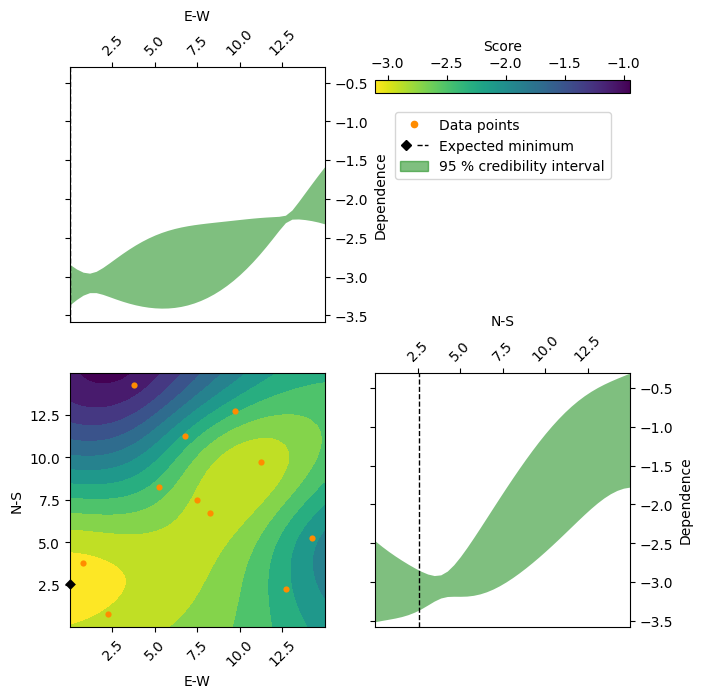

In [11]:
# For each of the next 9 positions
for index in range(9):
    # Find the place to dig
    new_dig_site = opt.ask()
    # Digging for gold
    gold_found = gold_map.get_score(new_dig_site)
    # Telling the optimiser how uch gold we found
    result = opt.tell(new_dig_site, gold_found)
    print(f"We dug at {new_dig_site} and found {-gold_found} mg of gold")
# Telling the optimiser about the very first dig
opt.tell([7.5,7.5],first_gold_found)
# plotting
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"]);

The coloured plot in the bottom left corner is the internal model of the gold content.
We can see that it has modelled the large features of the actual (**secret**) gold map, but are
lacking some details.

## Stopping here, or moving on?

We can also look at the amounts of gold we have found. The highest amount is 3.0 mg at
`[5.3,0.75]`, near the bottom a bit to the left of the middle.

Perhaps this is good enough - We might look at the 3.0 mg of gold and decide to simply
mine there in the future.

Or perhaps we want to continue and find an even better spot. Let's run the entire 
process of asking the ProcessOptimmizer for a place to dig, sending the Ms. Dixon's
team out to dig, and telling the ProcessOptimizer about the results a few more times.

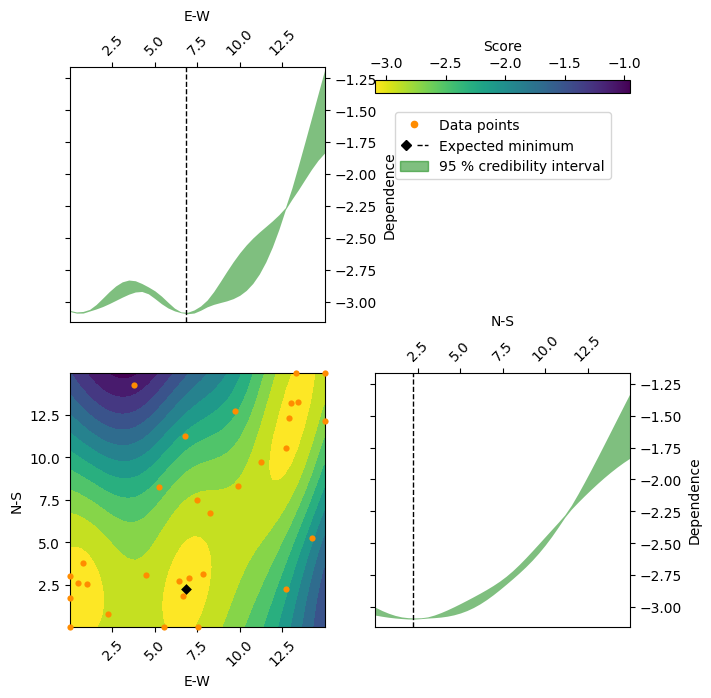

In [12]:
for i in range(20):
    # Finding new dig site.
    new_dig_site=opt.ask()
    # Digging and finding gold.
    gold_found = gold_map.get_score(new_dig_site)
    # Telling ProcessOptimizer how much gold we found at the new dig site
    opt.tell(new_dig_site,gold_found)
# plotting
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"]);

## Conclusion

Now, we have a really good model of the true map - The coloured map in the bottom left
looks quite a lot like the "secret gold map" from earlier. And most of the new dig sites
have been in places with a lot of gold, so we have gotten quite a lot of gold in the
process. This shows just how powerful a tool Bayesian Optimisation is to find the best
settings when each experiment is expensive, and even when the result can not be
modelled mathematically.